[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/ersip-sprint/blob/master/sprints/1/2%20-%20Load%20and%20display%20LiDAR%20raster.ipynb)

In [ ]:
! pip install sap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 17.4 MB/s eta 0:00:00


In [ ]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays

# Load and display LiDAR raster

The LiDAR raster files are located in the `data` folder. The rasters are in single band `TIFF` image format.

In [ ]:
! wget https://github.com/kshitijrajsharma/ersip-sprint/raw/master/data/data.zip
! unzip data.zip
! rm data.zip

--2025-12-15 07:45:52--  https://github.com/kshitijrajsharma/ersip-sprint/raw/master/data/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kshitijrajsharma/ersip-sprint/master/data/data.zip [following]
--2025-12-15 07:45:52--  https://raw.githubusercontent.com/kshitijrajsharma/ersip-sprint/master/data/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43502915 (41M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  41.49M   141MB/s    in 0.3s    

2025-12-15 07:45:54 (141 MB/s) - ‘data.zip’ saved [43502915/43502915]

Archive:  data.zip
   crea

In [ ]:
data_dir = Path('data')
list(data_dir.glob('*.tif'))

[PosixPath('data/dsm_vox_50cm_tile_-7_1.tif'),
 PosixPath('data/dsm_vox_50cm_tile_-12_0.tif'),
 PosixPath('data/dsm_vox_50cm_tile_-11_0.tif')]

## 1. Load and display a raster file

- Open the raster file and read the 2D array (tip: you can type `?function` to display docstrings, e.g. `?rio.open` )
- Read the 2D array
- Display the 2D array as an image
    + what can we do to visualize more details?

In [ ]:
dsm_50cm= rio.open(data_dir / 'dsm_vox_50cm_tile_-7_1.tif').read(1)

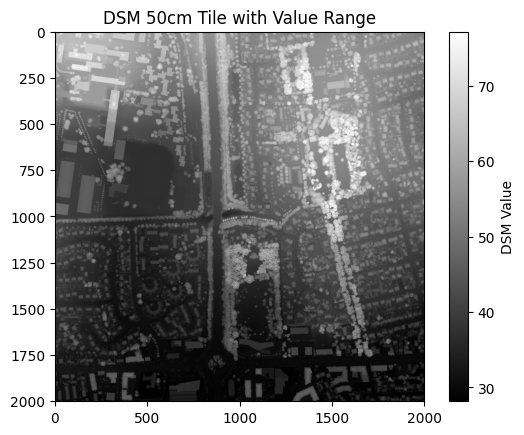

Minimum value of dsm_50cm: 28.15999984741211
Maximum value of dsm_50cm: 77.16000366210938


In [ ]:
plt.imshow(dsm_50cm, cmap='gray')
plt.colorbar(label='DSM Value')
plt.title('DSM with Value Range')
plt.show()
print(f"Minimum value of dsm_50cm: {np.min(dsm_50cm)}")
print(f"Maximum value of dsm_50cm: {np.max(dsm_50cm)}")

## 2. Visualize flat zones in the DSM

- Find the values of the flat zones
    + Sort the unique values in a list (or an array) of levels
- Display some flat zones
    + Display the flatzones of $i^{th}$ level

In [ ]:
print(dsm_50cm)

[[66.55506897 66.54903412 66.5374527  ... 53.18424225 53.13644028
  53.14580154]
 [66.59666443 66.57584381 66.57499695 ... 53.22000122 53.11000061
  53.11999893]
 [66.58999634 66.55999756 66.56999969 ... 53.13333511 53.11999893
  53.13268661]
 ...
 [30.71110535 30.77750015 30.86000061 ... 28.36499977 28.37750053
  28.37999916]
 [30.78487587 30.87333298 30.85666656 ... 29.97999954 29.90250015
  29.14500046]
 [30.76250076 30.84000015 30.80999947 ... 29.85000038 29.88333321
  29.90999985]]


In [ ]:
type(dsm_50cm)

numpy.ndarray

In [ ]:
dsm_50cm.shape

(2001, 2001)

In [ ]:
unique_dsm_values = np.unique(dsm_50cm)
print(unique_dsm_values)


[28.15999985 28.16042709 28.16098976 ... 77.15499878 77.15666962
 77.16000366]


In [104]:
filtered_dsm_30m = dsm_50cm.copy()
filtered_dsm_30m = np.where(filtered_dsm_30m < 30, filtered_dsm_30m, np.nan)

In [105]:
type(filtered_dsm_30m), filtered_dsm_30m.shape

(numpy.ndarray, (2001, 2001))

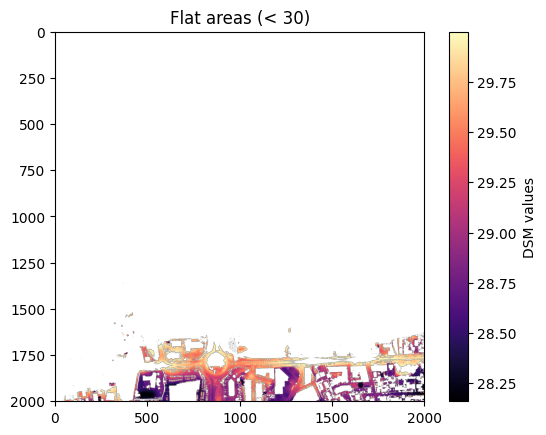

In [106]:
plt.imshow(filtered_dsm_30m, cmap='magma', vmin=np.nanmin(filtered_dsm_30m), vmax=np.nanmax(filtered_dsm_30m))
plt.colorbar(label='DSM values')
plt.title('Flat areas (< 30)')
plt.show()

## 3. Create a max-tree of the DSM

Building a max-tree from scratch is a challenging assignement 🙂

In [85]:
threshold_values = [30, 40, 50, 60]

In [97]:
max_tree = {}

sorted_threshold_values = sorted(threshold_values)
print(sorted_threshold_values)

for i, threshold in enumerate(sorted_threshold_values):
    node_key = f'node_{threshold}'

    mask_current = dsm_50cm > threshold
    total_row_indices, total_col_indices = np.where(mask_current)

    if i < len(sorted_threshold_values) - 1:
        next_threshold = sorted_threshold_values[i+1]
        mask_next = dsm_50cm > next_threshold
        mask_exclusive = mask_current & ~mask_next # pixels in current but not in next
        exclusive_row_indices, exclusive_col_indices = np.where(mask_exclusive)
    else:
        exclusive_row_indices, exclusive_col_indices = total_row_indices, total_col_indices

    max_tree[node_key] = {
        'threshold': threshold,
        'total_pixel_count': len(total_row_indices),
        'total_pixel_indices': list(zip(total_row_indices, total_col_indices)),
        'exclusive_pixel_count': len(exclusive_row_indices),
        'exclusive_pixel_indices': list(zip(exclusive_row_indices, exclusive_col_indices))
    }

[30, 40, 50, 60]


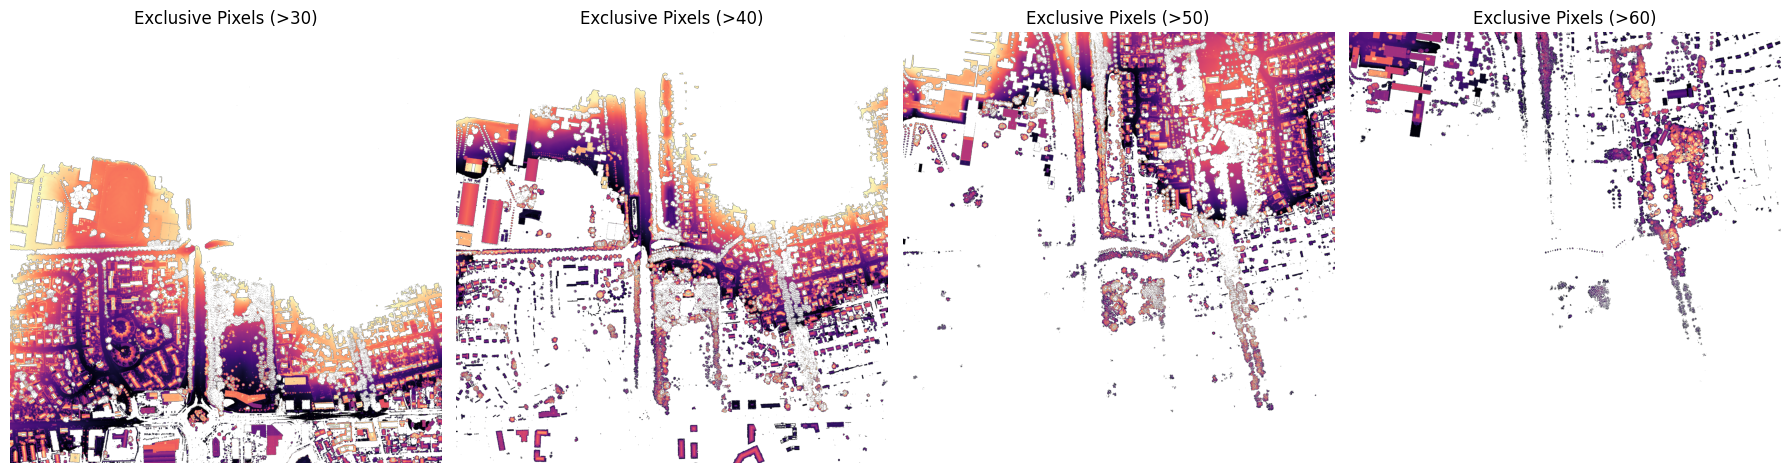

In [88]:
num_thresholds = len(sorted_threshold_values)
fig, axes = plt.subplots(1, num_thresholds, figsize=(18, 6))

for i, threshold in enumerate(sorted_threshold_values):
    ax = axes[i]
    node_key = f'node_{threshold}'

    exclusive_image = np.full(dsm_50cm.shape, np.nan) # empty image

    exclusive_indices = max_tree[node_key]['exclusive_pixel_indices']

    for r, c in exclusive_indices:
        exclusive_image[r, c] = dsm_50cm[r, c]
    ax.imshow(exclusive_image, cmap='magma', vmin=np.nanmin(exclusive_image), vmax=np.nanmax(exclusive_image))
    ax.set_title(f'Exclusive Pixels (>{threshold})')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [108]:
print("tree structure\n")

sorted_threshold_values = sorted(threshold_values)

for i, threshold in enumerate(sorted_threshold_values):
    node_key = f'node_{threshold}'
    node_data = max_tree[node_key]

    indent = "  " * i

    print(f"{indent}- Node: {node_key}")
    print(f"{indent}  Total Pixels > {node_data['threshold']}: {node_data['total_pixel_count']}")
    print(f"{indent}  Exclusive Pixels for this range: {node_data['exclusive_pixel_count']}")
    if i < len(sorted_threshold_values) - 1:
        print(f"{indent}  (Pixels are also included in: node_{sorted_threshold_values[i+1]} and higher)\n")
    else:
        print(f"{indent}  (highest pixels in this tree)\n")


tree structure

- Node: node_30
  Total Pixels > 30: 3752722
  Exclusive Pixels for this range: 1338637
  (Pixels are also included in: node_40 and higher)

  - Node: node_40
    Total Pixels > 40: 2414085
    Exclusive Pixels for this range: 995491
    (Pixels are also included in: node_50 and higher)

    - Node: node_50
      Total Pixels > 50: 1418594
      Exclusive Pixels for this range: 997075
      (Pixels are also included in: node_60 and higher)

      - Node: node_60
        Total Pixels > 60: 421519
        Exclusive Pixels for this range: 421519
        (highest pixels in this tree)

